RNN numba package
=================



## A few settings



### autoreload



In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

### project root



In [1]:
import os
import sys
# current_dir = os.path.dirname(os.path.abspath('__file__'))
# # Get parent directory (= the project root)
# project_root = os.path.join(current_dir, '..')
# # Append to system path
# sys.path.append(project_root)
# print(sys.path)

print("Python exe")
print(sys.executable)

Python exe
/home/leon/mambaforge/envs/dual_data/bin/python

### imports and setting up matplotlib



In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle as pkl

sns.set_context("poster")
sns.set_style("ticks")
plt.rc("axes.spines", top=False, right=False)
fig_path = '../figs/perf'
golden_ratio = (5**.5 - 1) / 2
width = 6
height = width * golden_ratio

matplotlib.rcParams['figure.figsize'] = [width, height]

matplotlib.rcParams['lines.markersize'] = 5
%matplotlib inline
%config InlineBackend.figure_format = 'png'

a test figure
2

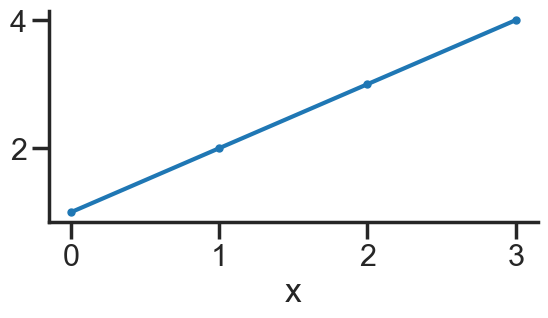

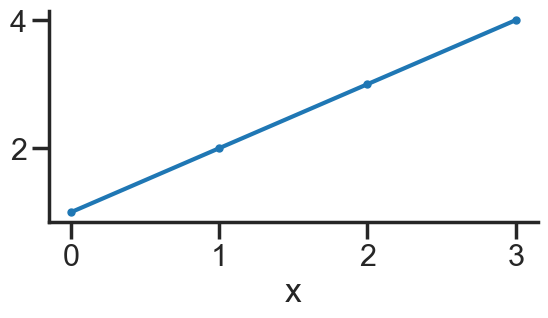

In [1]:
print('a test figure')
plt.figure()
plt.plot([1,2,3,4], '-o')
plt.xlabel('x')
# plt.show()

plt.figure()
plt.plot([1,2,3,4], '-o')
plt.xlabel('x')
# plt.show()

1+1

## Continuous rate model



### imports



In [1]:
import sys
sys.path.insert(0, '/home/leon/tmp/rnn_numba') # put here the path to the repo
from src.model.rate_model import Network

### Single trial



To run a simulation, first we need to define a network model.
The class Network takes two arguments:

1.  the name of the configuration file that defines the model. 
    This file is well detailed (check config<sub>bump.yml</sub> or config<sub>EI.yml</sub>)
2.  the name of the output file that will contain the simulation data.
    The model writes all relevant data to a single dataframe stored in an h5 format



In [1]:
conf_path = "/home/leon/tmp/rnn_numba/conf/"
model = Network('config_bump.yml', 'test', conf_path, VERBOSE=1)

Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
Saving to /home/leon/tmp/rnn_numba/data/simul/test.h5
Jab [[-2.75]]
SIGMA [[0.]]
KAPPA [[0.4]]
Iext [14.]

Then one just runs the model with



In [1]:
model.run()

#+begin_example
  Generating matrix Cij
  random connectivity
  with all to all cosine structure
  Saving matrix to /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Parameters:
  N 1000 Na [1000] K 1.0 Ka [1.]
  Iext [14.] Jab [-2.75]
  KAPPA [[0.4]] SIGMA [[0.]]
  MF Rates: [5.09090909]
  Running simulation
  times (s) 0.5 rates (Hz) [2.17]
  times (s) 1.0 rates (Hz) [2.16]
  STIM ON
  times (s) 1.5 rates (Hz) [6.26]
  STIM OFF
  times (s) 2.0 rates (Hz) [5.86]
  times (s) 2.5 rates (Hz) [5.86]
  CUE ON
  times (s) 3.0 rates (Hz) [5.88]
  CUE OFF
  times (s) 3.5 rates (Hz) [5.9]
  times (s) 4.0 rates (Hz) [5.87]
  saving data to /home/leon/tmp/rnn_numba/data/simul/test.h5
  Elapsed (with compilation) = 7.218026272952557s
#+end_example